**LangChain**

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [2]:
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Create a vector store
vectorstore = FAISS.from_texts(
    ["Elephants are Blue"],
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()
template = """Answer the question based only on the following context:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
model = ChatOpenAI()

In [4]:
output_parser = StrOutputParser()
retrieval_chain = (
    {"context":retriever, "question":RunnablePassthrough()}
    | prompt
    | model
    | output_parser
)
retrieval_chain.invoke("What is the color of an elephant?")

'Blue'

If we want to return the documents from the Vector Store, we may need to do modification in the LCEL, which is quite hard here.

**LangGrpah**

In [5]:
from typing import TypedDict
class RetrievalState(TypedDict):
    context: list[str]
    question: str
    answer: str
    formatted_prompt :str

In [ ]:
# functions for nodes

# Retrieve the Context based on the question from the Vector DB
def  retrieve_context(state:RetrievalState):
    docs = retriever.invoke(state['question'])
    state['context'] = docs
    return state

# Format the Prompt
def format_prompt(state:RetrievalState):
    context = state['context']
    question = state['question']
    state['formatted_prompt'] = prompt.invoke({'context':context, 'question':question})
    return state

# Generate the Answer
def generate_answer(state:RetrievalState):
    formatted_prompt = state['formatted_prompt']
    answer = model.invoke(formatted_prompt)
    state['answer'] = answer
    return state

**Define Workflow**

In [8]:
from langgraph.graph import StateGraph, END
workflow = StateGraph(RetrievalState)

# Define the nodes
workflow.add_node("retrieve_context", retrieve_context)
workflow.add_node("format_prompt",format_prompt)
workflow.add_node("generate_answer", generate_answer)

# Define the edges
workflow.add_edge("retrieve_context", "format_prompt")
workflow.add_edge("format_prompt", "generate_answer")
workflow.add_edge("generate_answer", END)

# Define the entry point
workflow.set_entry_point("retrieve_context")

# compile the workflow
app = workflow.compile()


**Visualize the LangGraph workflow**

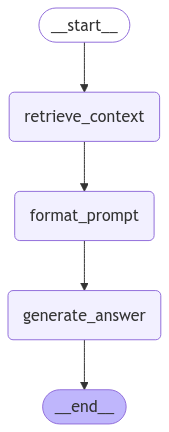

In [9]:
# using IPython display, visualize the workflow
from IPython.display import Image, display
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    print("No graph found")
    pass

In [11]:
# invoke the app
result = app.invoke({"question":"what is the color of a Elephant?"})
result

{'context': [Document(metadata={}, page_content='Elephants are Blue')],
 'question': 'what is the color of a Elephant?',
 'answer': AIMessage(content='Blue', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 39, 'total_tokens': 40, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-4c111b6c-d997-4f78-855d-02038954ccf0-0', usage_metadata={'input_tokens': 39, 'output_tokens': 1, 'total_tokens': 40, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 'formatted_prompt': ChatPromptValue(messages=[HumanMessage(content="Answer the question based only on the following context:\n[Document(metadata={}, page_c

In [13]:
# To access the document
docs= result['context']
docs

[Document(metadata={}, page_content='Elephants are Blue')]

In [15]:
# To retrieve the ans from the result
ans = result['answer'].content
ans

'Blue'

In [16]:
# To Retrieve the formatted Prompt
prompt = result['formatted_prompt']
prompt

ChatPromptValue(messages=[HumanMessage(content="Answer the question based only on the following context:\n[Document(metadata={}, page_content='Elephants are Blue')]\nQuestion: what is the color of a Elephant?\n", additional_kwargs={}, response_metadata={})])